# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31717371 entries, 0 to 31717370
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 967.9 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,3.171737e+07,3.171737e+07,3.171737e+07,3.171737e+07,3.171737e+07,3.171737e+07,3.171737e+07
mean,3.342299e+00,1.031456e+00,3.048986e-01,1.095140e+00,7.883911e-01,7.442783e-02,4.798512e-02
std,1.003193e+01,5.104504e+00,5.524211e-01,3.792497e+00,6.989674e-01,1.110550e+00,2.231912e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,2.902000e+04,1.437800e+04,6.730000e+02,9.939000e+03,2.368000e+03,3.390000e+03,1.320000e+02


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          31717371
n_isbns          16882949
n_loc_recs        9281528
n_ol_editions    25814137
n_ol_works       23754503
n_gr_books        1506186
n_gr_works        1505662
dtype: int64

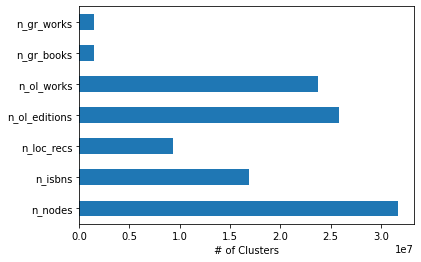

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,14834422
1,n_isbns,1,7480533
2,n_isbns,2,7435673
3,n_isbns,4,737604
4,n_isbns,3,617822


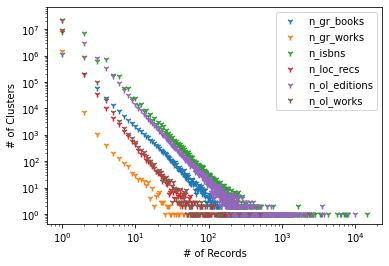

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9258 entries, 100026918 to 100674360
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        9258 non-null   uint32
 1   n_isbns        9258 non-null   uint32
 2   n_loc_recs     9258 non-null   uint32
 3   n_ol_editions  9258 non-null   uint32
 4   n_ol_works     9258 non-null   uint32
 5   n_gr_books     9258 non-null   uint32
 6   n_gr_works     9258 non-null   uint32
dtypes: uint32(7)
memory usage: 325.5 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?

In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.0002918905227044196

Less than 1%. Not bad, but let's look.

In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100026918,29020,14378,673,9939,508,3390,132
100073294,17883,7331,496,8126,360,1481,89
100227025,6811,3314,192,2555,258,422,70
100122502,454,165,4,93,76,60,56
104486307,315,141,1,51,18,53,51


## Large Cluster Debugging

We have some pretty big clusters:

In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100026918,29020,14378,673,9939,508,3390,132
100073294,17883,7331,496,8126,360,1481,89
100044980,15635,7836,186,6168,89,1333,23
102066477,11281,7520,0,3760,1,0,0
100063034,11098,5647,178,3484,145,1599,45


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?

In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,OL,AZ14,GR,BX,LOC
isbn_id,,,,,,
1,0813523923,2,0,0,0,1
2,0813523931,2,0,0,1,1
3,010836321X,1,0,0,0,0
4,9780108363214,1,0,0,0,0
5,1560002948,1,0,0,0,1


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,32715078,309665508
1,32715072,309633417
2,32715073,309633417
3,32715074,309633417
4,32715075,309633417


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,OL,AZ14,GR,BX,LOC
32616544,12349192,0001004735,1,0,0,0,0
32618508,6834614,0001848259,1,0,0,0,0
32621387,6631389,0001849123,1,0,0,0,0
32612819,11278348,0001956795,1,0,0,0,0
32619372,1764565,0003302245,1,0,0,0,0
...,...,...,...,...,...,...,...
32620420,32276393,B073GF59RD,0,0,1,0,0
32610343,32380080,B073GGNYFL,0,0,1,0,0
32621324,32403192,B073MZ23QX,0,0,1,0,0
32615246,32290521,B074P9CM5T,0,0,1,0,0


What are the things with the highest record count (besides ratings)?

In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,OL,AZ14,GR,BX,LOC,btot
32619071,13445848,014143984X,3,1614,1,9,1,1618
32617517,3061337,0141439769,1,1353,1,2,0,1355
32611734,231627,0140621199,2,1185,1,18,0,1188
32608780,22256994,0140390839,1,993,1,11,0,995
32610047,2369418,006440188X,2,549,1,50,0,552
32613451,14228444,0141321008,1,509,1,0,0,511
32621186,30630791,B0084AVKZ2,0,377,1,0,0,378
32622160,29797914,0199538794,0,363,1,0,0,364
32620809,30455263,B002RKRMSY,0,329,1,0,0,330
32618352,30455339,B002RKSZJO,0,328,1,0,0,329
